# GOAL: Pixel-level masks on satelite pictures of houses.

- Use the pixel-level results from the SAM model (lots of overlapping predictions) by checking which ones "agree" with the satellite-building-segmentation labels.

In [78]:
!pip install huggingface_hub datasets segment-anything

**Load satellite dataset**

In [2]:
from datasets import load_dataset
# From https://huggingface.co/datasets/keremberke/satellite-building-segmentation?row=0
ds = load_dataset("keremberke/satellite-building-segmentation", name="full")
example = ds['train'][0]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.53k [00:00<?, ?B/s]

satellite-building-segmentation.py:   0%|          | 0.00/6.29k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/349M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/99.7M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/50.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6764 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1934 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/967 [00:00<?, ? examples/s]

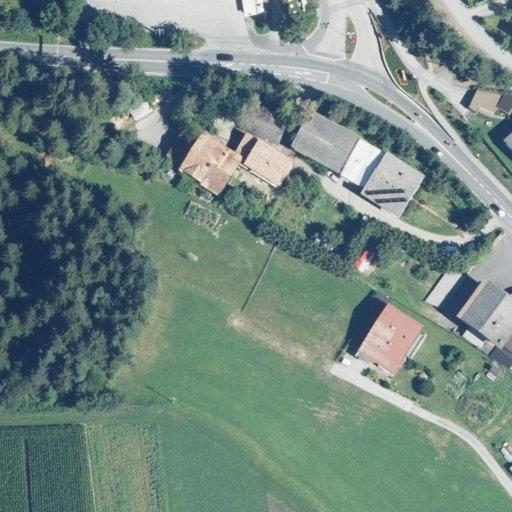

dict_keys(['image_id', 'image', 'width', 'height', 'objects'])

In [3]:
display(example["image"])
example["objects"]['bbox']
example.keys()

In [4]:
example["objects"]['bbox']

[[242.0, 0.0, 22.5, 13.5],
 [469.0, 90.0, 34.0, 24.0],
 [497.0, 92.0, 15.0, 23.0],
 [126.0, 97.0, 26.0, 25.0],
 [164.0, 105.0, 260.0, 115.0],
 [504.0, 135.0, 7.5, 16.0],
 [427.0, 270.0, 39.0, 42.0],
 [456.0, 283.0, 56.0, 88.0],
 [356.0, 293.0, 67.0, 84.0],
 [462.0, 331.0, 16.0, 14.0]]

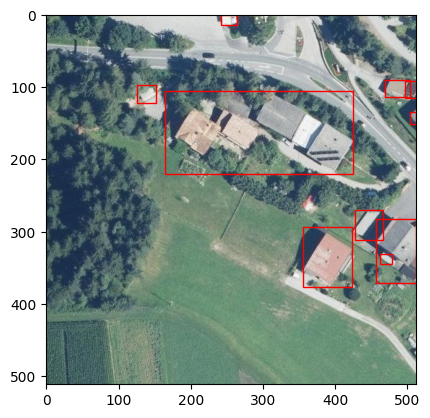

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

image = example["image"].copy()  # Create a copy to avoid modifying the original

fig, ax = plt.subplots(1)
ax.imshow(image)

for bbox in example["objects"]["bbox"]:
  x_min, y_min, width, height = bbox
  rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
  ax.add_patch(rect)

plt.show()

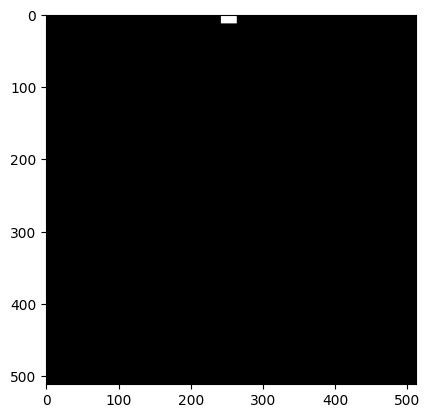

In [65]:
def make_mask(labelled_bbox, image):
  x_min_ones, y_min_ones, width_ones, height_ones = labelled_bbox
  x_min_ones, y_min_ones, width_ones, height_ones = int(x_min_ones), int(y_min_ones), int(width_ones), int(height_ones)
  mask_instance = np.zeros((image.width,image.height))

  last_x = x_min_ones+width_ones
  last_y = y_min_ones+height_ones
  mask_instance[x_min_ones:last_x, y_min_ones:last_y] = np.ones((int(width_ones),int(height_ones)))
  return mask_instance.T

labelled_bbox = example["objects"]["bbox"][0]
mask_instance = make_mask(labelled_bbox, image)
plt.imshow(mask_instance, cmap='gray')
plt.show()

In [15]:
# From: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb
using_colab=True
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-8ovtcwfl
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-8ovtcwfl
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
--2024-12-29 08:53:49--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99846 (98K) [image/jpeg]
Saving to: ‘images/dog.jpg’

dog.jpg             100%[===================>]  97.51K  --

In [16]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [17]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [19]:
masks = mask_generator.generate(np.array(example["image"]))

In [20]:
print(len(masks))
print(masks[0].keys())

141
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


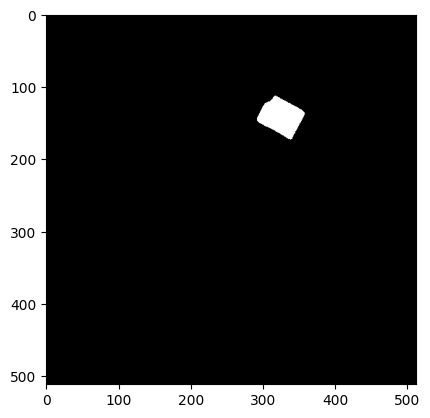

In [43]:
binary_array = masks[10]['segmentation'].astype(int)
plt.imshow(binary_array, cmap='gray')
plt.show()

In [29]:
for m in masks:
  print(m['bbox'])

[0, 423, 162, 88]
[0, 141, 155, 266]
[179, 132, 61, 62]
[378, 0, 133, 89]
[150, 22, 54, 31]
[86, 423, 78, 88]
[347, 294, 75, 80]
[0, 427, 27, 84]
[88, 0, 159, 37]
[0, 424, 92, 87]
[292, 113, 65, 60]
[301, 113, 57, 42]
[361, 152, 62, 63]
[479, 293, 32, 54]
[425, 273, 36, 33]
[432, 0, 79, 70]
[475, 0, 36, 52]
[217, 183, 49, 34]
[345, 290, 40, 64]
[243, 138, 49, 48]
[266, 493, 28, 18]
[469, 233, 42, 55]
[254, 0, 64, 42]
[135, 108, 31, 38]
[0, 423, 287, 88]
[236, 0, 28, 16]
[184, 163, 46, 31]
[292, 125, 56, 47]
[184, 201, 37, 35]
[216, 53, 17, 7]
[457, 280, 54, 66]
[71, 5, 79, 46]
[292, 114, 131, 101]
[457, 281, 47, 48]
[0, 50, 20, 46]
[469, 89, 42, 27]
[445, 371, 22, 27]
[276, 168, 46, 40]
[440, 344, 23, 26]
[227, 128, 17, 22]
[410, 264, 18, 16]
[216, 170, 282, 104]
[490, 347, 21, 21]
[181, 114, 242, 101]
[98, 128, 72, 51]
[236, 95, 46, 48]
[20, 0, 65, 35]
[489, 116, 22, 42]
[354, 250, 21, 24]
[240, 137, 17, 25]
[411, 372, 23, 24]
[320, 176, 153, 68]
[438, 274, 40, 47]
[0, 0, 85, 42]
[402

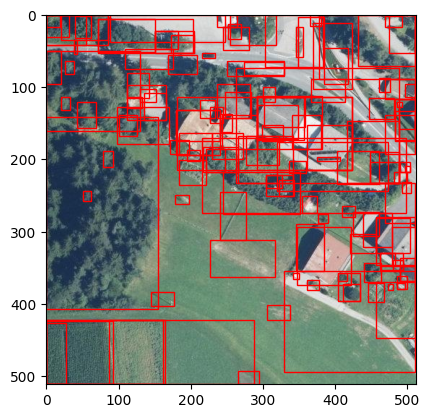

In [30]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

image2 = example["image"].copy()  # Create a copy to avoid modifying the original

fig, ax = plt.subplots(1)
ax.imshow(image)

for m in masks:
  bbox = m['bbox']
  x_min, y_min, width, height = bbox
  rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
  ax.add_patch(rect)

plt.show()

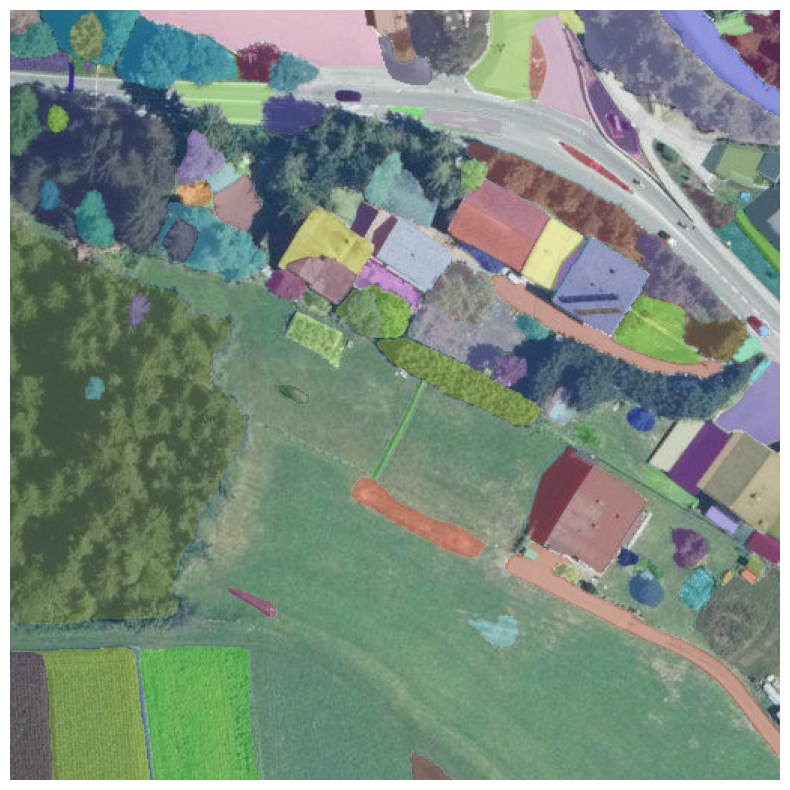

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

0.6153457849570924


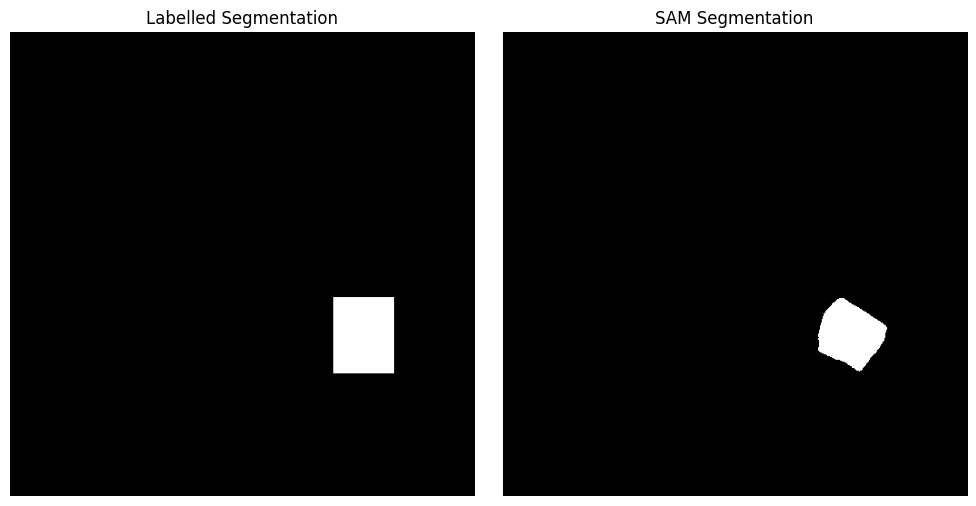

0.35501519756838906


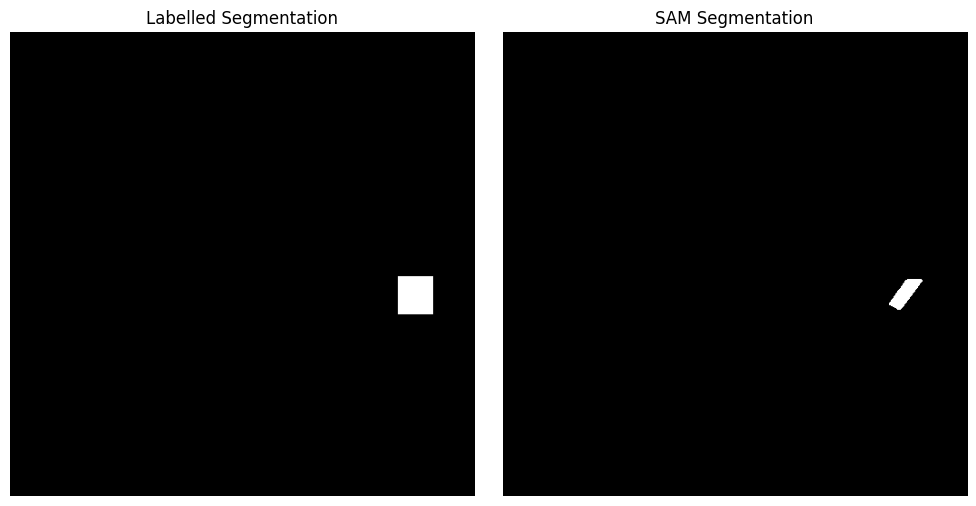

0.7282051282051282


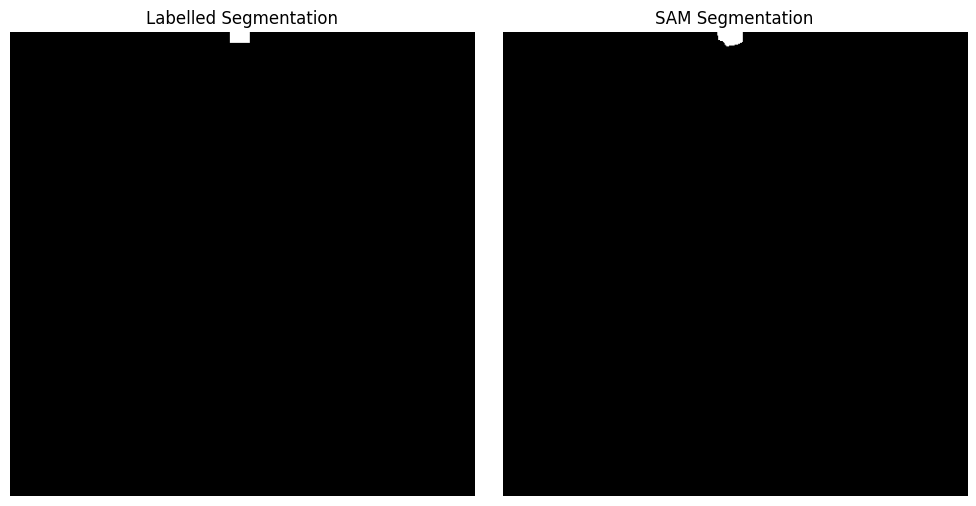

0.47393939393939394


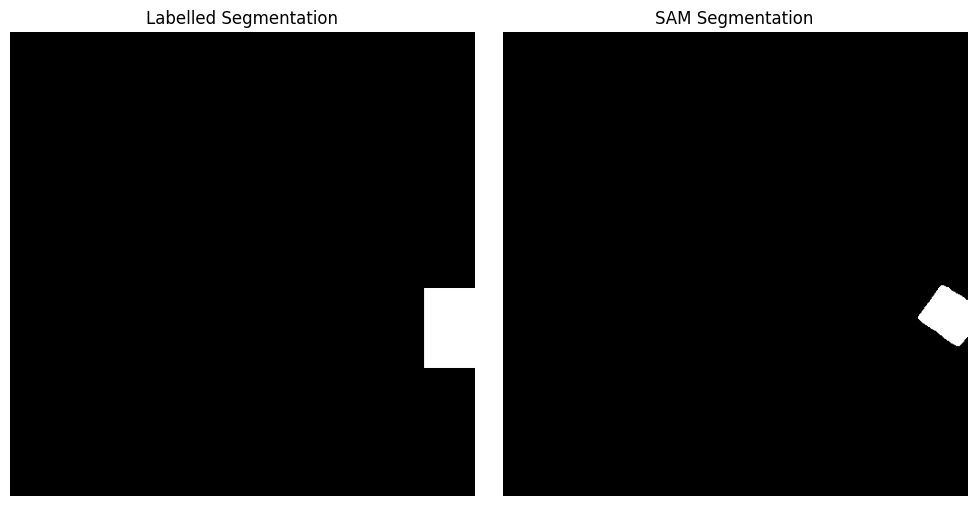

0.6468899521531101


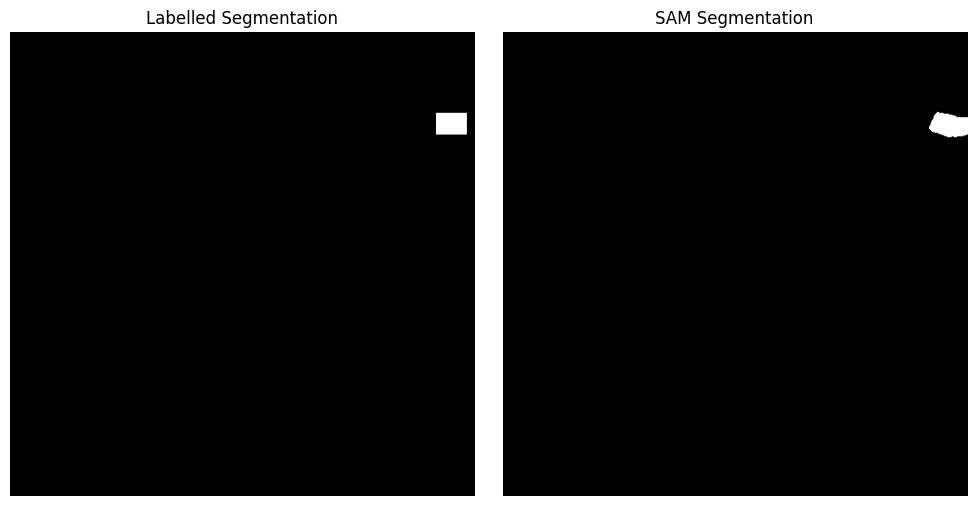

0.31856540084388185


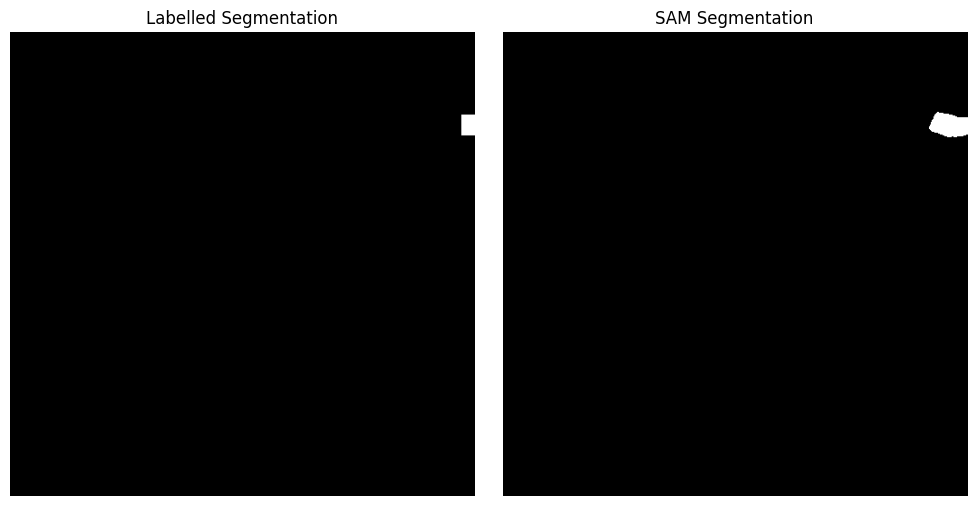

0.32177961717537507


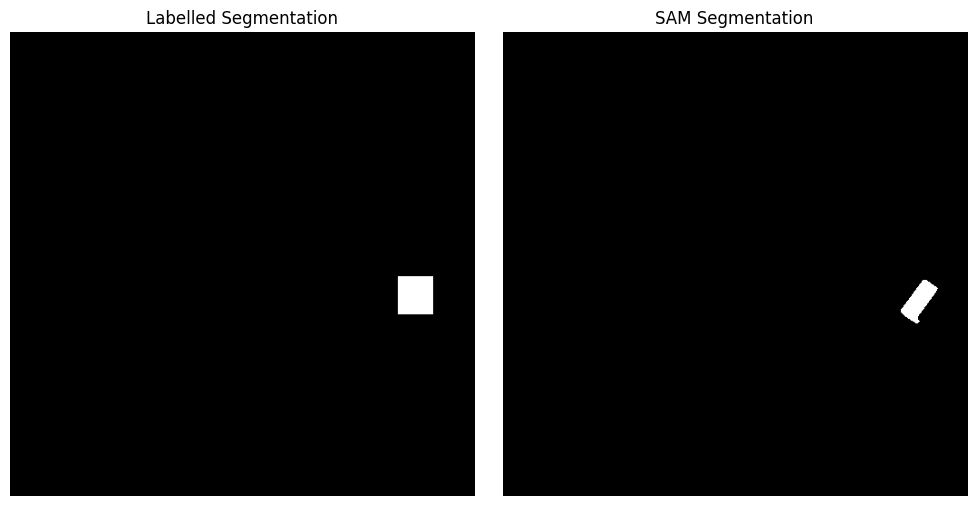

0.3608490566037736


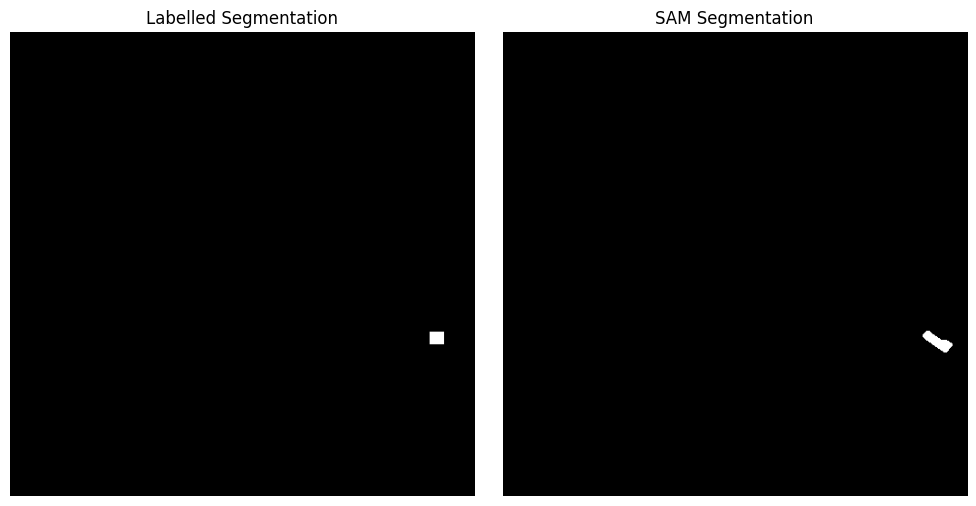

0.7043478260869566


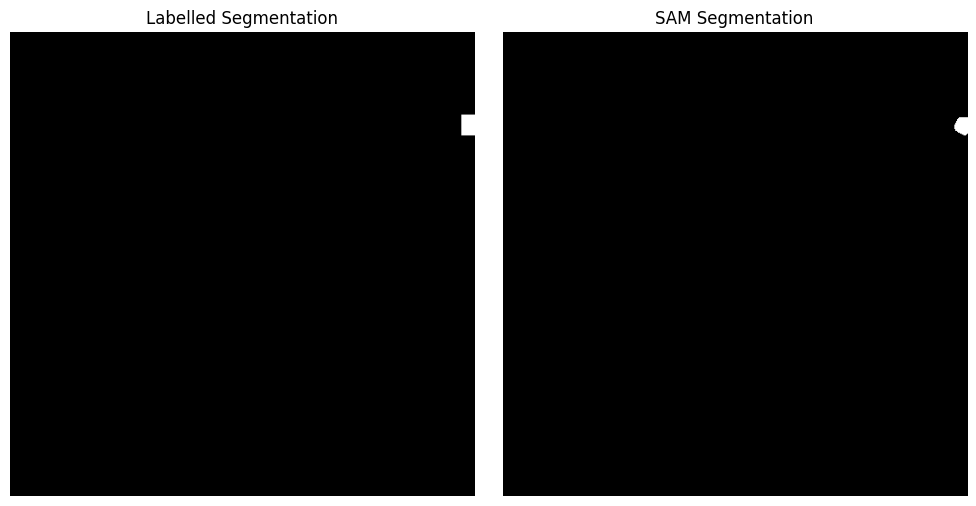

0.40735068912710565


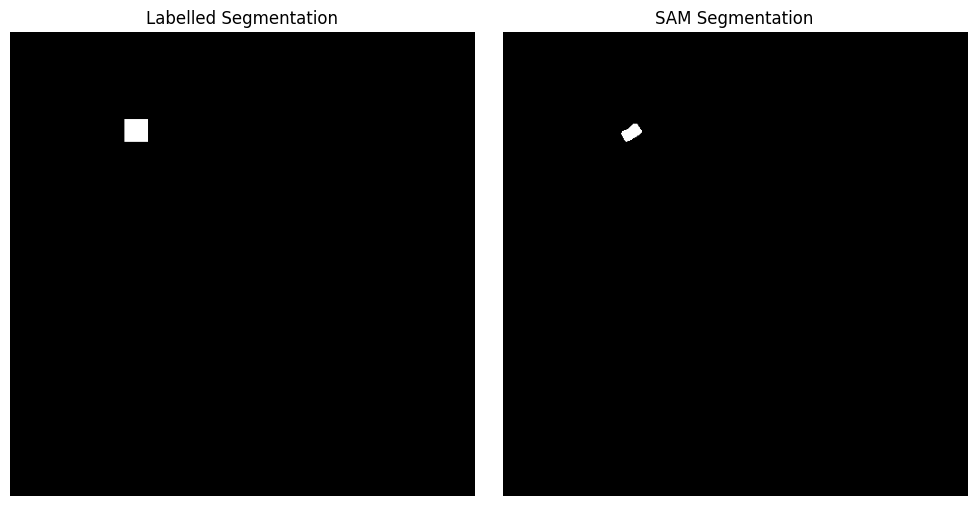

0.5120274914089347


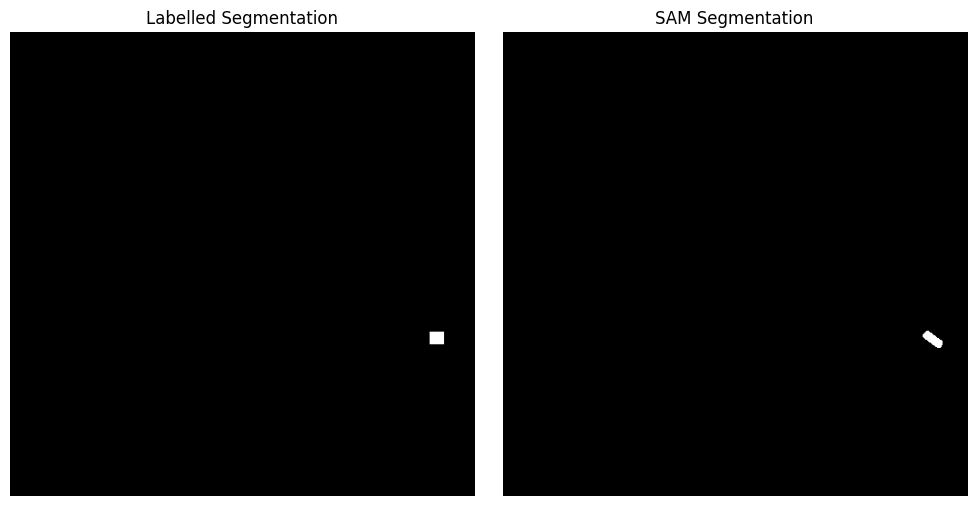

In [77]:
from scipy.spatial import distance

for sam_box in masks:
  sam_seg = sam_box['segmentation'].astype(int)
  for label_box in example["objects"]["bbox"]:
    label_seg = make_mask(label_box, image)
    iou = np.sum(np.logical_and(sam_seg, label_seg)) / np.sum(np.logical_or(sam_seg, label_seg))
    if iou>0.3:
      print(iou)
      # Create a figure with 1 row and 2 columns
      fig, axes = plt.subplots(1, 2, figsize=(10, 5))

      # Display the first image in the first subplot
      axes[0].imshow(label_seg, cmap='gray')
      axes[0].set_title('Labelled Segmentation')
      axes[0].axis('off')  # Hide axes for better visualization

      # Display the second image in the second subplot
      axes[1].imshow(sam_seg, cmap='gray')
      axes[1].set_title('SAM Segmentation')
      axes[1].axis('off')  # Hide axes for better visualization

      # Adjust spacing between subplots
      plt.tight_layout()
      plt.show()